### Singeltask 

In [3]:
import os 
import pandas as pd

stl_results_fcn = pd.DataFrame(columns=["dataset","best_model_train_acc", "accuracy", "precision", "recall", "duration"])
stl_results_res = pd.DataFrame(columns=["dataset","best_model_train_acc", "accuracy", "precision", "recall", "duration"])

for idx, dataset in enumerate(os.listdir('./archives/ucr')):
    fcn_model = pd.read_csv(f'./results/ucr/{dataset}/fcn/fcn_1.0/original/df_best_model.csv')
    fcn_metrics = pd.read_csv(f'./results/ucr/{dataset}/fcn/fcn_1.0/original/task1_df_metrics.csv')
    res_model = pd.read_csv(f'./results/ucr/{dataset}/resnet/resnet_1.0/original/df_best_model.csv')
    res_metrics = pd.read_csv(f'./results/ucr/{dataset}/resnet/resnet_1.0/original/task1_df_metrics.csv')

    #Read STL results for FCN classifier
    stl_results_fcn.loc[idx] = [dataset, fcn_model["best_model_train_acc"].values[0], 
                                fcn_metrics["accuracy"].values[0], fcn_metrics["precision"].values[0],
                                fcn_metrics["recall"].values[0], fcn_metrics["duration"].values[0]] 
    #Read STL results for ResNet classifier
    stl_results_res.loc[idx] = [dataset, res_model["best_model_train_acc"].values[0], 
                                res_metrics["accuracy"].values[0], res_metrics["precision"].values[0],
                                res_metrics["recall"].values[0], res_metrics["duration"].values[0]] 


In [2]:
stl_results_fcn

,dataset,best_model_train_acc,accuracy,precision,recall,duration
0,GunPoint,0.480000,0.506667,0.253333,0.500000,10.021661
1,Coffee,1.000000,1.000000,1.000000,1.000000,83.390118
2,Beef,0.833333,0.366667,0.248000,0.366667,51.792605
3,Meat,0.983333,0.750000,0.803313,0.750000,83.233952
4,ECG200,1.000000,0.890000,0.887155,0.871528,41.492362
5,ECG5000,1.000000,0.939556,0.709101,0.548548,308.225050


In [3]:
stl_results_res

,dataset,best_model_train_acc,accuracy,precision,recall,duration
0,GunPoint,1.0,0.993333,0.993506,0.993243,147.183564
1,Coffee,1.0,1.000000,1.000000,1.000000,146.827705
2,Beef,1.0,0.633333,0.665195,0.633333,146.145196
3,Meat,1.0,0.916667,0.933333,0.916667,145.907373
4,ECG200,1.0,0.870000,0.870266,0.843750,146.415622
5,ECG5000,1.0,0.929556,0.675259,0.565985,863.733498


### Test Similarity of Attribution methods

- raw unscaled attribution vectors
- pearson 

In [4]:
import numpy as np
from utils.utils import read_dataset


archive = 'ucr'
dataset_name = 'GunPoint'
data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'

train_val = []
test_val  = []

for idx, dataset in enumerate(os.listdir('./archives/ucr')):
    ylen = 1
    data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
    ylen = len(data[0][0])
    try:
        _,cy,_,cy1 = read_dataset(data_p, archive, dataset, 'fcn_cam_raw', ylen)[dataset]
        _,igy,_,igy1 = read_dataset(data_p, archive, dataset, 'fcn_ig_raw', ylen)[dataset]
        train_val.append([dataset,np.mean(np.corrcoef(cy, igy, rowvar=True)), np.mean(np.square(cy- igy))])
        test_val.append([dataset,np.mean(np.corrcoef(cy1,igy1,rowvar=True)),  np.mean(np.square(cy1- igy1))])
    except: 
        print("import error")

    
pd.DataFrame(train_val,columns=["dataset", "correlation","mse"])
pd.DataFrame(test_val,columns=["dataset", "correlation", "mse"])


import error


,dataset,correlation,mse
0,GunPoint,0.029085,106.627741
1,Coffee,0.317611,136.904533
2,Beef,0.036095,181.528538
3,Meat,0.085237,153.056471
4,ECG200,0.087100,191.425921


### Calcualte Custom Metrics for Attribution Prediction Task 


In [56]:
import tensorflow_addons as tfa
from utils.explanations import integrated_gradients
from keras.utils import CustomObjectScope
import tensorflow.keras as keras
import tensorflow as tf
import os
from utils.explanations import minmax_norm
from utils.explanations import calculate_ig_attributions
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.utils import read_dataset
from sklearn.preprocessing import normalize

# Load model to calculate custom metrics 
def load_model(root_dir, archive_name, dataset_name, classifier, data_source): 
    with CustomObjectScope({'InstanceNormalization':tfa.layers.InstanceNormalization()}):
        model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                                + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                                + f'best_model.hdf5'
        model =keras.models.load_model(model_path ,compile=False)
        return model
    

def norm(values): 
    if not type(values) == np.ndarray:
        return normalize(values.numpy().reshape(1,-1))[0]
    else: 
        return normalize(values.reshape(1,-1))[0]
    
#define shared trunk
network = 'fcn' 
    
#store custom metrics for model
models_train  = dict()
models_test   = dict()
# Loop over data
for idx, dataset in enumerate(os.listdir('./archives/ucr')):
    print(dataset)
    ylen = 1
    #Just for now:

    data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
    #assertion,each ts has same length
    ylen = len(data[0][0])

    for model in [ 'fcn_mt_ae','fcn_mt_conv']: 
        print(model)
        try: 
            #if dataset != "Coffee": 
            #    continue

            #Load initial values after STL training
            #cam_data_stl = read_dataset(data_p, archive, dataset, 'fcn_cam_raw', ylen)[dataset]
            ig_data_stl  = read_dataset(data_p, archive, dataset, 'fcn_ig_raw', ylen)[dataset]
            #Load required models
            #cam_link = f'./results/ucr/{dataset}/fcn/fcn_mt_ae_0.0/fcn_cam_raw/best_model.hdf5'
            ig_link  = f'./results/ucr/{dataset}/fcn/{model}_0.0/fcn_ig_raw/best_model.hdf5'
            #cam_model =keras.models.load_model(cam_link ,compile=False)
            ig_model = keras.models.load_model(ig_link ,compile=False)

            #Calculate new  attributions
            ig_attributions = calculate_ig_attributions(data_p, archive, f"{model}_0.0", dataset, "fcn_ig_raw", task=1)
             # train and test data
            # 1,3 are the labels:  
            for t in [1,3]:
                
                tc = t 
                #Pearson and mse [p,m]
                pm1 = 0; pm2 = 0; mm1 = 0; mm2 = 0
                #predict values for all timeseries 
                print("pred", t, data[t-1].shape)

                pred = ig_model.predict(data[t-1])
                #run loop
                for ts in range(len(data[t])):                
                    #small workaround
                    #structure of attributions 0 --> train 1 --> test set
                    pm1 += np.corrcoef(norm(pred[1][ts].flatten()),norm(ig_data_stl[t][ts]))[0,1]
                    pm2 += np.corrcoef(norm(pred[1][ts].flatten()),norm(ig_attributions[0 if t == 1 else 1][ts][2]))[0,1]
                    mm1 += mean_squared_error(norm(pred[1][ts].flatten()),norm(ig_data_stl[t][ts]))
                    mm2 += mean_squared_error(norm(pred[1][ts].flatten()),norm(ig_attributions[0 if t == 1 else 1][ts][2]))

                #Init for model 
                l = len(data[t])
                if t == 1: 
                    print("Update")
                    #f'{dataset}_{model.split("_")[-1]}'
                    models_train[f'{dataset}_{model.split("_")[-1]}'] = {"model" : model, "pm1":pm1/l,"pm2": pm2/l,"mm1":mm1/l, "mm2": mm2/l}
                else: 
                    models_test[f'{dataset}_{model.split("_")[-1]}'] =  {"model" : model , "pm1":pm1/l, "pm2": 
                                                                         pm2/l, "mm1":mm1/l,  "mm2": mm2/l}
                
        except Exception as e: 
            print(dataset,"error", e)
            pass

    

    

GunPoint
fcn_mt_ae
GunPoint error Unable to open file (file signature not found)
fcn_mt_conv
pred 1 (50, 150)
2/2 [==============================] - 0s 15ms/step
Update
pred 3 (150, 150)
5/5 [==============================] - 0s 19ms/step
Coffee
fcn_mt_ae
pred 1 (28, 286)
1/1 [==============================] - 0s 466ms/step
Update
pred 3 (28, 286)
1/1 [==============================] - 0s 95ms/step
fcn_mt_conv
pred 1 (28, 286)
1/1 [==============================] - 0s 315ms/step
Update
pred 3 (28, 286)
1/1 [==============================] - 0s 61ms/step
Beef
fcn_mt_ae
pred 1 (30, 470)
1/1 [==============================] - 1s 597ms/step
Update
pred 3 (30, 470)
1/1 [==============================] - 0s 136ms/step
fcn_mt_conv
pred 1 (30, 470)
1/1 [==============================] - 0s 268ms/step
Update
pred 3 (30, 470)
1/1 [==============================] - 0s 73ms/step
Meat
fcn_mt_ae
Meat error No file or directory found at ./results/ucr/Meat/fcn/fcn_mt_ae_0.0/fcn_ig_raw/best_model.hdf5


In [61]:
#pd.DataFrame(models_train).T
pd.DataFrame(models_test).T


,model,pm1,pm2,mm1,mm2
GunPoint_conv,fcn_mt_conv,0.311211,0.082311,0.008995,0.016704
Coffee_ae,fcn_mt_ae,0.426652,0.227006,0.003749,0.005162
Coffee_conv,fcn_mt_conv,0.543868,-0.08098,0.003144,0.007697
Beef_ae,fcn_mt_ae,0.182915,0.170058,0.003452,0.003547
Beef_conv,fcn_mt_conv,0.064232,0.035716,0.003866,0.003687
Meat_conv,fcn_mt_conv,0.0413,0.10527,0.004205,0.003894
ECG200_ae,fcn_mt_ae,-0.065935,0.803523,0.02027,0.012756
ECG200_conv,fcn_mt_conv,0.546143,0.221311,0.009173,0.016607


In [73]:
#print(pred[1])
for ts in range(len(data[t])): 
    #print(pred[1][ts].flatten().shape,ig_attributions[ts][2].shape)

#### Visualization of the Experiment


In [52]:
from scipy.interpolate import interp1d
def prepare_visualize_attribution(ts,attribution):
    max_length = 2000    
    #prepare values
    minimum = np.min(attribution)
    cas = attribution - minimum
    cas = cas / max(cas)
    cas = cas * 100
    xv= np.linspace(0, len(ts) - 1, max_length, endpoint=True)
    f = interp1d(range(len(ts)),ts)
    yv = f(xv)
    f = interp1d(range(len(ts)),cas)
    cas = f(xv).astype(int)
    return xv,yv,cas

4/4 [==============================] - 0s 30ms/step
(96,) (96,)


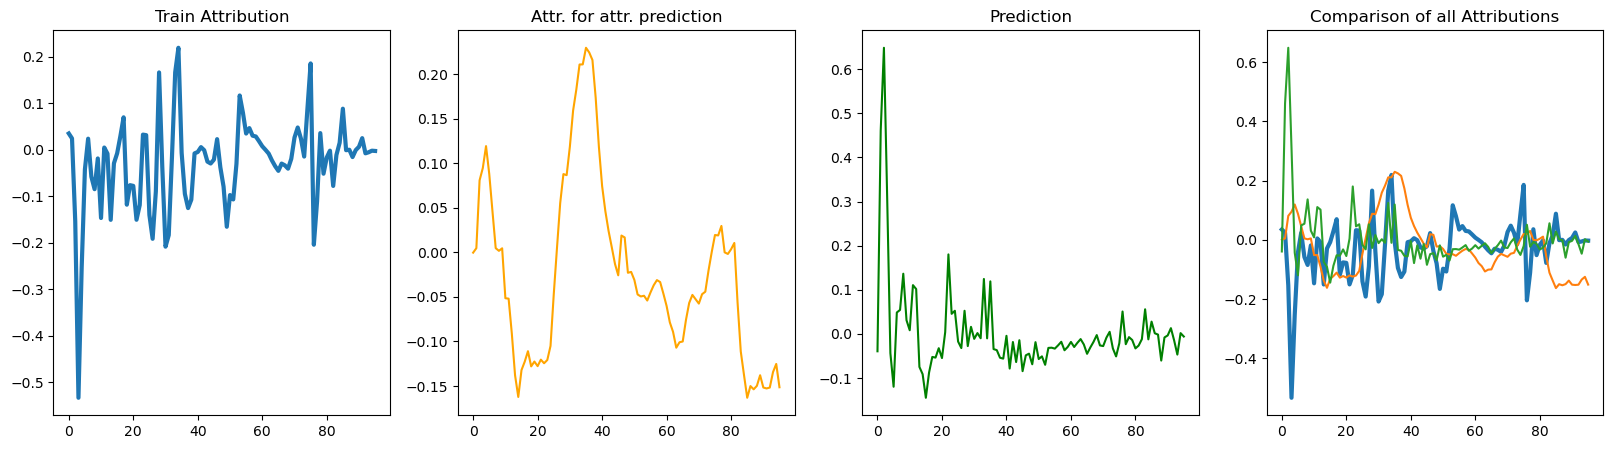

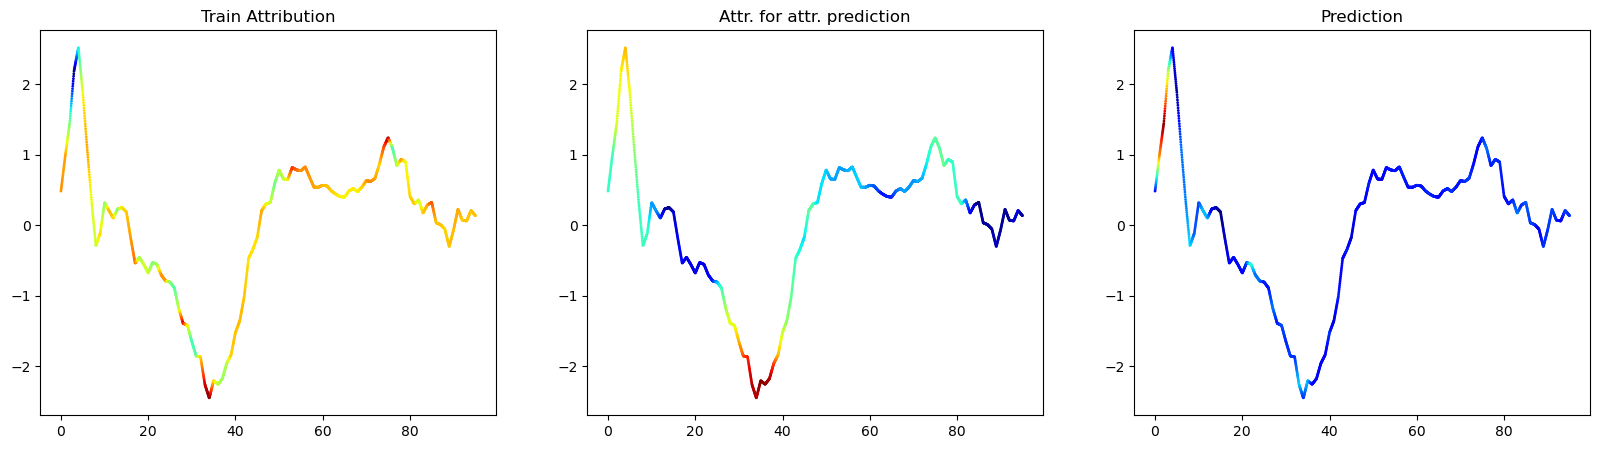

<Figure size 640x480 with 0 Axes>

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt 


def visualize_experiment_1(dataset,model,ts, train):


    ylen = 1 
    idx = 0 if  train else 2
    data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
    #assertion,each ts has same length
    ylen = len(data[0][0])
    ig_data_stl  = read_dataset(data_p, archive, dataset, 'fcn_ig_raw', ylen)[dataset]

    ig_link  = f'./results/ucr/{dataset}/fcn/{model}_0.0/fcn_ig_raw/best_model.hdf5'
    #cam_model =keras.models.load_model(cam_link ,compile=False)
    ig_model = keras.models.load_model(ig_link ,compile=False)

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    fig = plt.gcf()
    
    #diff between train and test

    #Get x values
    x = ig_data_stl[idx]
    #Get attribution froms singeltask values
    stl_att = ig_data_stl[idx+1]
    #Get predicted values
    pred = ig_model.predict(x)[1]
    #Get attribution values used for prediction
    stl_pred_att = calculate_ig_attributions(data_p, archive, f"{model}_0.0", dataset, "fcn_ig_raw")
    #Get attributen used for specific time series
    pred_att = stl_pred_att[0 if t == 1 else 1]

    #First row raw attribution vector: 
    axes[0].plot(norm(stl_att[ts]), label="train", linewidth=3)
    axes[0].set_title('Train Attribution')
    axes[1].plot(norm(pred[ts]), label="predicted", color='orange')
    axes[1].set_title('Attr. for attr. prediction')
    axes[2].plot(norm(pred_att[ts][2]), label="attributed", color='green')
    axes[2].set_title('Prediction')
    axes[3].plot(norm(stl_att[ts]), linewidth=3)
    axes[3].plot(norm(pred[ts]), )
    axes[3].plot(norm(pred_att[ts][2]), label="attributed")
    axes[3].set_title('Comparison of all Attributions')


    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    fig = plt.gcf()

    #Second row visulaization
    print(x[ts].shape,stl_att[ts].shape)
    #transformed x-values,y-values,attributionvalues for visualization only!
    xv,yv,av =prepare_visualize_attribution(x[ts],norm(stl_att[ts]))
    axes[0].scatter(xv,yv,c=av, cmap='jet', vmin=0,vmax=100, s=1, label='train')
    axes[0].set_title('Train Attribution')
    xv,yv,av =prepare_visualize_attribution(x[ts],norm(pred[ts]))
    axes[1].scatter(xv,yv,c=av, cmap='jet', vmin=0,vmax=100,s=1, label='attributed')
    axes[1].set_title('Attr. for attr. prediction')
    xv,yv,av =prepare_visualize_attribution(x[ts],norm(pred_att[ts][2]))
    axes[2].scatter(xv,yv,c=av, cmap='jet', vmin=0,vmax=100,s=1, label='predicted')
    axes[2].set_title('Prediction')
    #axes[1][3].plot()

    #plt.legend()
    plt.show()
    plt.draw()

visualize_experiment_1('ECG200','fcn_mt_ae',10, train=True)